# Neural Machine Translation Using Encoder Decoder

# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import string
from string import digits
import matplotlib.pyplot as plt
import re
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, TimeDistributed
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Model

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

In [3]:
cd '/content/gdrive/My Drive/MachineTranslation/'

/content/gdrive/My Drive/MachineTranslation


# Loading the Data

In [4]:
df = pd.read_csv('deu.txt', delimiter = '\t',names=["eng", "ger", "c"])

In [5]:
df.shape

(200519, 3)

In [6]:
df = df.drop(['c'], axis = 1)

In [7]:
df.sample(10)

,eng,ger
180504,Tom was fired for constantly being late to work.,"Tom wurde entlassen, weil er immer zu spät zur..."
13268,You must choose.,Ihr müsst wählen.
32778,This is what I need.,"Das ist es, was ich brauche."
168780,"You can do whatever you want to, of course.","Du kannst natürlich tun, was immer dir beliebt."
147822,I'd like to help you reach your goals.,"Ich würde Ihnen gerne helfen, Ihre Ziele zu er..."
145057,Tom isn't the right man for this job.,Tom ist nicht der Richtige für diesen Job.
40291,What is today's date?,Der Wievielte ist heute?
189214,"All horses are animals, but not all animals ar...","Alle Pferde sind Tiere, jedoch nicht alle Tier..."
24348,Here are your keys.,Hier sind deine Schlüssel.
121064,I'm sure Tom would appreciate it.,"Ich bin sicher, Tom würde das zu schätzen wissen."


# Preprocessing Data

In [8]:
# Lowercase all characters
df.eng=df.eng.apply(lambda x: x.lower())
df.ger=df.ger.apply(lambda x: x.lower())

In [9]:
# Remove quotes
df.eng=df.eng.apply(lambda x: re.sub("'", '', x))
df.ger=df.ger.apply(lambda x: re.sub("'", '', x))

In [10]:
# Remove all the special characters
exclude = set(string.punctuation) # Set of all special characters

df.eng=df.eng.apply(lambda x: ''.join(ch for ch in x if ch not in exclude))
df.ger=df.ger.apply(lambda x: ''.join(ch for ch in x if ch not in exclude))

In [11]:
# Remove extra spaces
df.eng=df.eng.apply(lambda x: x.strip())
df.ger=df.ger.apply(lambda x: x.strip())

In [12]:
# Add start and end tokens to target sequences
df.eng = df.eng.apply(lambda x: 'startseq ' + x + ' endseq')
df.ger = df.ger.apply(lambda x : 'startseq '+ x + ' endseq')

In [13]:
df.sample(10)

,eng,ger
149639,startseq tom is going to change his mind again...,startseq tom wird es sich wieder anders überle...
3392,startseq i went there endseq,startseq ich ging hin endseq
44370,startseq my shopping bag broke endseq,startseq meine einkaufstasche ging kaputt endseq
57329,startseq is boston very far away endseq,startseq ist boston sehr weit weg endseq
83473,startseq you should finish the work endseq,startseq du solltest die arbeit fertigstellen ...
90734,startseq you must help set the table endseq,startseq ihr müsst helfen den tisch zu decken ...
32731,startseq this is a great day endseq,startseq heute ist ein großer tag endseq
18384,startseq do you like these endseq,startseq magst du diese endseq
54433,startseq youre too good for me endseq,startseq du bist zu gut für mich endseq
29368,startseq dont open the door endseq,startseq öffne die tür nicht endseq


# Train, Val, Test Split

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(df['eng'], df['ger'],  train_size=0.8)

In [15]:
c = 0
for i in df['eng']:
  if len(i.split()) < 20:
    c+=1
(1.0*c)/len(df)

0.996519033109082

# Tokenization

In [16]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

### English Tokenization

In [17]:
def pad_sequence(t, padding_var = 20):
    t = sequence.pad_sequences(t, maxlen=padding_var, padding='post') 
    return t

def build_data(train, test):
  print("="*100)
  print("Fitting the Tokenizer...")
  tokenizer = Tokenizer(lower=True)
  tokenizer.fit_on_texts(train)
  print("Done...")
  print('Found %s unique tokens.' % len(tokenizer.word_counts))
  print("="*100)
  print()
  print("Processing Text to sequence process")
  train = tokenizer.texts_to_sequences(train)
  test = tokenizer.texts_to_sequences(test)
  print("Done")
  print("="*100)
  print()
  print("Starting Padding Process...")  
  train = pad_sequence(train)
  test = pad_sequence(test)
  print("Done")
  return train, test, tokenizer

## English Tokenization

In [18]:
X_train, X_test, tokenizer_eng = build_data(X_train, X_test)

Fitting the Tokenizer...
Done...
Found 15125 unique tokens.

Processing Text to sequence process
Done

Starting Padding Process...
Done


## German Tokenization

In [19]:
Y_train, Y_test, tokenizer_ger = build_data(Y_train, Y_test)

Fitting the Tokenizer...
Done...
Found 31766 unique tokens.

Processing Text to sequence process
Done

Starting Padding Process...
Done


In [20]:
num_encoder_tokens = len(tokenizer_eng.word_counts)
num_decoder_tokens = len(tokenizer_ger.word_counts)+1
num_encoder_tokens, num_decoder_tokens

(15125, 31767)

# Processing Embedding Matrix

In [22]:
# !python -m spacy download en_core_web_lg
# !python -m spacy download de_core_news_md

In [23]:
import en_core_web_lg
import de_core_news_md
eng = en_core_web_lg.load()
ger = de_core_news_md.load()

In [24]:
def build_embedding_matrix(tokenizer, build_y = False):
    base = eng
    if(build_y):
      base = ger
    embedding_matrix = np.zeros((len(tokenizer.word_counts) + 1, 300))

    for word, i in tokenizer.word_index.items():  
        embedding_matrix[i] = base(word).vector
    
    return embedding_matrix 
embedding_matrix_enc = build_embedding_matrix(tokenizer_eng)
embedding_matrix_dec = build_embedding_matrix(tokenizer_ger, build_y = True)

In [25]:
embedding_matrix_enc.shape, embedding_matrix_dec.shape

((15126, 300), (31767, 300))

# Defining The Model

In [65]:
def build_model(latent_dim=256):
    
    embedding_enc = Embedding(*embedding_matrix_enc.shape, weights=[embedding_matrix_enc], trainable=False, mask_zero=True, name = "Encoder_Embedding")
    embedding_dec = Embedding(*embedding_matrix_dec.shape, weights=[embedding_matrix_dec], trainable=False, mask_zero=True, name = "Decoder_Embedding")
    
    """ Encoder question """
    encoder_inputs = Input(shape=(None,), name="encoder_input")
    enc_emb = embedding_enc(encoder_inputs) 
    _, state_h, state_c = LSTM(latent_dim, return_state=True, name="Encoder_LSTM")(enc_emb)
    encoder_states = [state_h, state_c]

    """ decoder Model """
    decoder_inputs = Input(shape=(None,), name="decoder_input") 
    dec_emb_layer = embedding_dec(decoder_inputs)
    lstm_layer = LSTM(latent_dim, return_sequences=True, return_state=True, name = "Decoder_LSTM")
    decoder_outputs, _, _ = lstm_layer(dec_emb_layer,initial_state=encoder_states)
 
    dense = Dense(num_decoder_tokens, activation='softmax', name='softmax_layer')
    dense_time = TimeDistributed(dense, name='time_distributed_layer')
    decoder_outputs = dense_time(decoder_outputs)    # Final decoder model 

    model = Model(inputs = [encoder_inputs, decoder_inputs], outputs = [decoder_outputs])
    
    """ Inference Models """
    # Encode the input sequence to get the "thought vectors"
    encoder_model = Model([encoder_inputs], outputs = encoder_states)

    # Decoder setup
    # Below tensors will hold the states of the previous time step  
    decoder_state_input_h = Input(shape=(latent_dim,), name="decoder_state1")
    decoder_state_input_c = Input(shape=(latent_dim,), name="decoder_state2")

    decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
     
    # To predict the next word in the sequence, set the initial states to the states from the previous time step
    decoder_outputs, state_h, state_c = lstm_layer(dec_emb_layer, initial_state=decoder_states_inputs)
    decoder_states = [state_h, state_c]

    decoder_outputs = dense_time(decoder_outputs)    # Final decoder model 
    # Final decoder model
    decoder_model = Model(inputs = [decoder_inputs, decoder_states_inputs], outputs = [decoder_outputs, decoder_states])   

    model.compile(optimizer='adam', loss='categorical_crossentropy')

    return model, encoder_model, decoder_model

In [66]:
model, encoder_model, decoder_model = build_model()

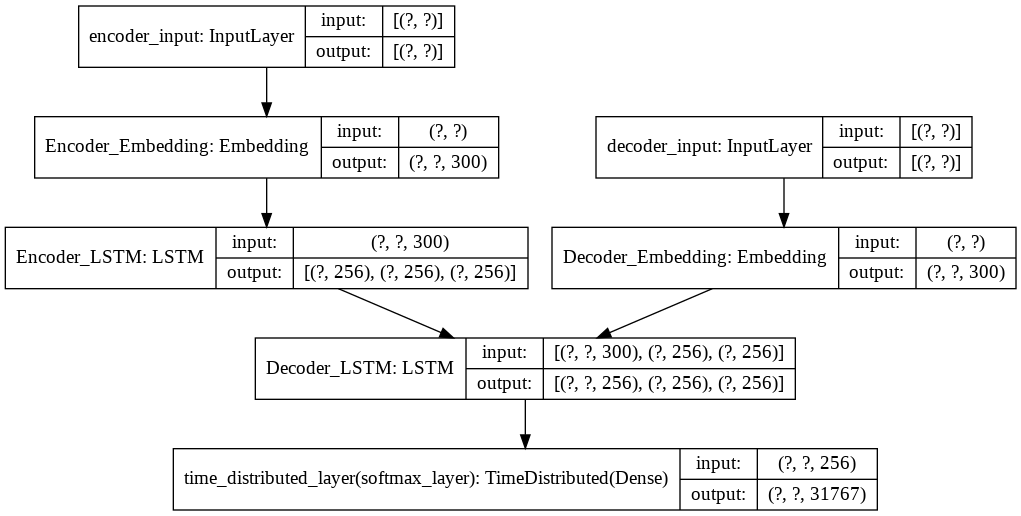

In [67]:
plot_model(
    model, to_file='model.png', show_shapes=True, show_layer_names=True,
    rankdir='TB', expand_nested=False, dpi=96
)

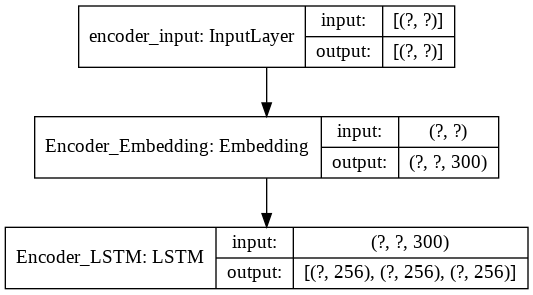

In [68]:
plot_model(
    encoder_model, to_file='encoder_model.png', show_shapes=True, show_layer_names=True,
    rankdir='TB', expand_nested=False, dpi=96
)

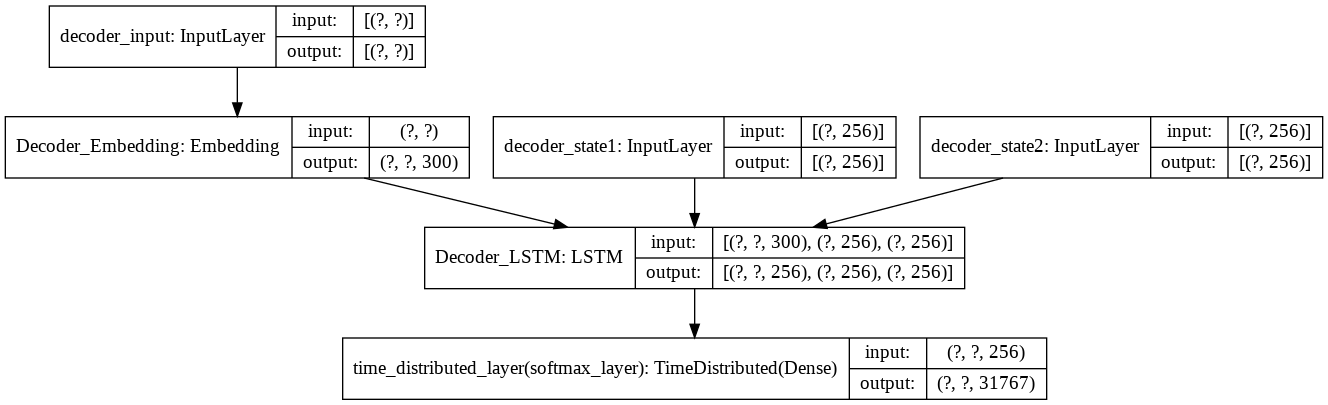

In [69]:
plot_model(
    decoder_model, to_file='decoder_model.png', show_shapes=True, show_layer_names=True,
    rankdir='TB', expand_nested=False, dpi=96
)

In [70]:
def generate_batch(X, y, batch_size):
    ''' Generate a batch of data '''
    while True:
        for j in range(0, len(X), batch_size):
            encoder_input_data = np.array(X[j:j+batch_size])
            decoder_input_data = np.array(y[j:j+batch_size])
            decoder_target_data = np.zeros((encoder_input_data.shape[0], 20, num_decoder_tokens),dtype='float32')
            for i, target_text in enumerate(y[j:j+batch_size]):
                for t, index in enumerate(target_text):
                    if t>0:
                        # decoder target sequence (one hot encoded)
                        # does not include the START_ token
                        decoder_target_data[i, t - 1, index] = 1.
           
            yield([encoder_input_data, decoder_input_data], decoder_target_data)

In [71]:
train_samples = len(X_train)
val_samples = len(X_test)
batch_size = 64
epochs = 20
train_samples, val_samples

(160415, 40104)

In [72]:
filepath="model/weights-improvement-{epoch:02d}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', save_best_only=True, mode='min')
callbacks_list = [checkpoint]

In [73]:
model.fit_generator(generator = generate_batch(X_train, Y_train, batch_size = batch_size),
  steps_per_epoch = len(X_train)//batch_size,
  epochs=epochs,
  validation_data = generate_batch(X_test, Y_test, batch_size = batch_size),
  validation_steps = len(X_test)//batch_size,
  callbacks = callbacks_list)

Epoch 1/20
2506/2506 [==============================] - 274s 110ms/step - loss: 1.6812 - val_loss: 1.2447
Epoch 2/20
2506/2506 [==============================] - 271s 108ms/step - loss: 1.1083 - val_loss: 0.9790
Epoch 3/20
2506/2506 [==============================] - 265s 106ms/step - loss: 0.8731 - val_loss: 0.8570
Epoch 4/20
2506/2506 [==============================] - 263s 105ms/step - loss: 0.7285 - val_loss: 0.7969
Epoch 5/20
2506/2506 [==============================] - 263s 105ms/step - loss: 0.6305 - val_loss: 0.7634
Epoch 6/20
2506/2506 [==============================] - 262s 105ms/step - loss: 0.5598 - val_loss: 0.7469
Epoch 7/20
2506/2506 [==============================] - 261s 104ms/step - loss: 0.5077 - val_loss: 0.7388
Epoch 8/20
2506/2506 [==============================] - 259s 103ms/step - loss: 0.4681 - val_loss: 0.7363
Epoch 9/20
2506/2506 [==============================] - 263s 105ms/step - loss: 0.4368 - val_loss: 0.7390
Epoch 10/20
2506/2506 [=======================

In [75]:
model.save_weights('model/final_model.h5')

In [88]:
# saving
import pickle
with open('model/tokenizer_eng.pickle', 'wb') as handle:
    pickle.dump(tokenizer_eng, handle, protocol=pickle.HIGHEST_PROTOCOL)
# saving
with open('model/tokenizer_ger.pickle', 'wb') as handle:
    pickle.dump(tokenizer_ger, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# model.load_weights('model/final_model.h5')

# Inference

In [82]:
def pad_sequence(t, padding_var = 20):
    t = sequence.pad_sequences(t, maxlen=padding_var, padding='post') 
    return t


def decode_sequence(text, tokenizer_text = tokenizer_eng, tokenizer_Y = tokenizer_ger):
    # Text to sequence
    text = "startseq " + text + " endseq"
    text = pad_sequence(tokenizer_text.texts_to_sequences([text]))

    # Encode the input as state vectors.
    input_seq = [np.array(text).reshape(1, 20)]
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))

    # Populate the first character of target sequence with the start character.
    target_seq[0, 0] = tokenizer_Y.word_index['startseq']
  
    decoded_sentence = ''
    while True:
        output_tokens, states_value = decoder_model.predict([target_seq, states_value])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = tokenizer_Y.index_word[sampled_token_index]

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == 'endseq' or len(decoded_sentence.split()) > 25): 
            break

        decoded_sentence += ' '+sampled_char 

        

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index
 

    return decoded_sentence

In [83]:
index = 22432
print("English: {}".format(df.iloc[index]['eng']))
print("Acutal Ger: {}".format(df.iloc[index]['ger']))
print("Predicted Ger: {}".format(decode_sequence(df.iloc[index]['eng']))) 

English: startseq tom will remember endseq
Acutal Ger: startseq tom wird sich erinnern endseq
Predicted Ger:  tom wird sich erinnern an den wir erinnern


In [89]:
index = 3523
print("English: {}".format(df.iloc[index]['eng']))
print("Acutal Ger: {}".format(df.iloc[index]['ger']))
print("Predicted Ger: {}".format(decode_sequence(df.iloc[index]['eng']))) 

English: startseq im so tired endseq
Acutal Ger: startseq ich bin so müde endseq
Predicted Ger:  ich gebe das zu dass ich zu weinen war


In [84]:
a = "hi there, how are you!"
print("English Text: {}".format(a))
print("Translated Text: {}".format(decode_sequence(a)))

English Text: hi there, how are you!
Translated Text:  hey wie gehts


In [94]:
a = "let us go for a trip"
print("English Text: {}".format(a))
print("Translated Text: {}".format(decode_sequence(a)))

English Text: let us go for a trip
Translated Text:  lasst uns eine reise gehen


In [85]:
a = "Finally, I am done with this assignment"
print("English Text: {}".format(a))
print("Translated Text: {}".format(decode_sequence(a)))

English Text: Finally, I am done with this assignment
Translated Text:  schon ich bin mit diesem wochenende zu tun
